This notebook was used to do the Cramer-Rao calculations for Toliman, both to get the photon noise limit for the separation measurement, and to estimate the limit for the plate scale measurement from the sidelobes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
sys.path.append('/Users/cheetham/code/toliman/Toliman/COIN/new_sims/')
sys.path.append('/Users/cheetham/Dropbox/code/toliman/Toliman/lib/')
import functions
import photometry

In [2]:
def cramer_rao_bound(image):
    """ Calculate the Cramer-Rao bound on the accuracy of a position measurement for a single image.
    Returns the expected standard deviation of the position measurement in the x and y directions.
    """
    # calculate derivative at each pixel. Use symmetric two-point derivative
    dg_dx = (image[:,2:]-image[:,:-2])/2
    dg_dy = (image[2:]-image[:-2])/2

    var_x = 1/(np.sum(dg_dx**2 / image[:,1:-1]))
    var_y = 1/(np.sum(dg_dy**2 / image[1:-1]))

    std_x = np.sqrt(var_x)
    std_y = np.sqrt(var_y)
    
    return std_x,std_y

### Calculation for the central PSF

In [3]:
### Choose an image:
# The bound is proportional to sqrt(n_photons), so we should rescale the image. 
# It's better to use an image before photon noise so we don't get zeros.

# Toliman PSF images:
image = np.load('shift_invariance_data/model_psf.npy');nphots =  35000
# image = np.load('shift_invariance_round_pupil/model_psf.npy') ;nphots =1.# 2500000

image *= nphots/np.nanmax(image) # for peak photons
# image *= nphots/np.sum(image) # for total photons

# Crop the PSF
sz = 100
image = image[image.shape[0]//2-sz:image.shape[0]//2+sz,image.shape[1]//2-sz:image.shape[1]//2+sz]

In [4]:
std_x,std_y = cramer_rao_bound(image)

# And for the secondary
# I should work it out for the secondary PSF but instead I'll just scale it by the binary contrast ratio
std_sec_x = std_x*np.sqrt(3.94) # magic number is the binary contrast ratio
std_sec_y = std_y*np.sqrt(3.94) # magic number is the binary contrast ratio

# Add them together
std_sep_x = np.sqrt(std_x**2+std_sec_x**2)
std_sep_y = np.sqrt(std_y**2+std_sec_y**2)
std_sep = np.mean([std_sep_x,std_sep_y])

fact = 1e6
print(std_x*fact,std_y*fact)
print('1D Position error (upix): {0}'.format(std_sep*fact))

323.8102009207852 321.6264870250386
1D Position error (upix): 717.2773660941047


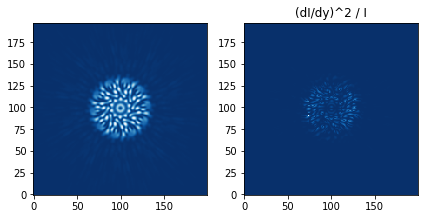

In [5]:
# Display the term inside the sum to check that it's not dominated by noisy pixels
dg_dx = (image[:,2:]-image[:,:-2])/2
dg_dy = (image[2:]-image[:-2])/2

cmap = 'Blues_r'
plt.figure(figsize=(6,4))
plt.subplot(122)
plt.title('(dI/dy)^2 / I')
plt.imshow(dg_dy**2 / image[1:-1],origin='lowerleft',cmap=cmap)
# plt.imshow(dg_dx**2 / image[:,1:-1],origin='lowerleft',cmap=cmap)
plt.subplot(121)
plt.imshow(image[1:-1],origin='lowerleft',cmap=cmap)
plt.tight_layout()

### Calculation for the Sidelobes

In [6]:
# Sidelobes:
# We'll rotate these so they're aligned with the axes.
im = fits.getdata('../../Sidelobe_fit/sims_prenoise/jitter/0.fits'); nphots = 3500
image = functions.fft_rotate(im,45.,pad=2,return_full=True)

image *= nphots/np.nanmax(image) # for peak photons
# image *= nphots/np.sum(image) # for total photons

# Crop the sidelobes
image = image[740:1060,1900:2100]

std_x,std_y = cramer_rao_bound(image)

In [7]:
# Convert to a separation measurement over the distance between the diffraction spots
diff_spot_diam = 1543. # pix
print('X,Y position limits for sidelobes (upix):',std_x*1e6,std_y*1e6)
print('1D Plate scale limit (upix):',np.sqrt(2)*std_y/diff_spot_diam*1e6)
print('Plate scale limit from x+y measurements (upix):',std_y/diff_spot_diam*1e6)

X,Y position limits for sidelobes (upix): 4252.040261976561 46672.41840664853
1D Plate scale limit (upix): 42.77690673974986
Plate scale limit from x+y measurements (upix): 30.247840833861655


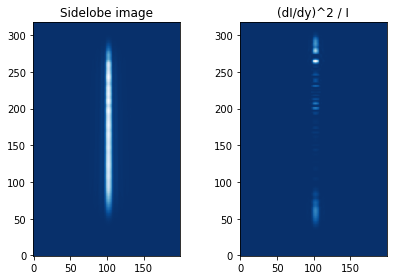

In [8]:
# Display the term inside the sum to check that it's not dominated by noisy pixels
dg_dx = (image[:,2:]-image[:,:-2])/2
dg_dy = (image[2:]-image[:-2])/2

cmap = 'Blues_r'
plt.figure(figsize=(6,4))
plt.subplot(122)
plt.title('(dI/dy)^2 / I')
plt.imshow(dg_dy**2 / image[1:-1],origin='lowerleft',cmap=cmap)
# plt.imshow(dg_dx**2 / image[:,1:-1],origin='lowerleft',cmap=cmap)
plt.subplot(121)
plt.imshow(image[1:-1],origin='lowerleft',cmap=cmap)
plt.title('Sidelobe image')
plt.tight_layout()
# plt.savefig('/Users/cheetham/Google Drive/Backup/astro_things/reports/toliman/sidelobe_gradients.pdf')

from filter: 18.59794111957477
total: 29.284550716924496
63.5 % from the filter edges


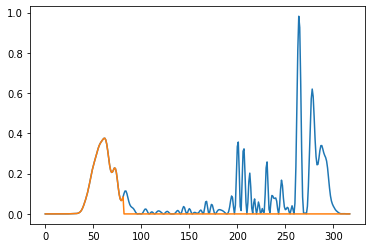

In [9]:
# How much of the term inside the sum is provided by the filter edges, and how much by the spectral lines?

grad = dg_dy**2 / image[1:-1]
plt.plot(grad[:,grad.shape[1]//2-1])

# Sum together the contribution from the filter edge on one side and double it (since the other side is contaminated by spectral lines)
sum_range = np.zeros(grad.shape[0])
sum_range[0:82] = 1 # outside filter edge
# sum_range[260:270]=1 # brightest line 
plt.plot(grad[:,grad.shape[1]//2-1]*sum_range)

from_filter = 2*np.sum(grad[:,grad.shape[1]//2-1]*sum_range)
total = np.sum(grad[:,grad.shape[1]//2-1])
print('from filter:',from_filter)
print('total:',total)
print(round(from_filter/total*100,1),'% from the filter edges')